In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyedfread import edf
import pickle
from glob import glob
from os.path import join
%matplotlib inline
import seaborn as sns
from PSPupil import Preprocessing as PS
from PSPupil import dataset as dt
import mne
import scipy

from scipy import stats, signal, interpolate
from scipy.stats import ttest_ind, linregress, f_oneway
from scipy.optimize import curve_fit
import svgutils.transform as sg
from decim.adjuvant import slurm_submit as slu
import matplotlib.colors
import itertools
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc


def smaller_than(value):
    logs=np.append(np.logspace(-15, 1, 17), .05)
    sorteds=np.sort(np.append(logs, value))
    index=np.where(sorteds==value)[0]
    return sorteds[index+1][0]

def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c

def permutation_cluster_test(x1, x2):
    f, clusters, pvalues, h0=mne.stats.permutation_cluster_test([x1,x2],
                                                                     threshold=dict(start=0, step=0.2))
    return pvalues

def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)


def smaller_than(value):
    logs=np.append(np.logspace(-15, 1, 17), .05)
    sorteds=np.sort(np.append(logs, value))
    index=np.where(sorteds==value)[0]
    return sorteds[index+1][0]

def p_annot(p_value):
    if p_value < 0.001:
        text = '<{0}'.format(smaller_than(p_value))
    else:
        text = '%.3f' % p_value

In [15]:
#Plotting parameters
palette = sns.color_palette("Paired")

'''
baseline_color = palette[4]
followup_color = palette[5]
ips_color = palette[0]
control_color = palette[2]
'''

'''
baseline_color = rgb_to_hex(196, 98, 74)
ips_color = rgb_to_hex(123, 118, 19)
control_color = rgb_to_hex(228, 193, 91)
'''

baseline_color = '#F0746E'
follow_color = baseline_color
ips_color = '#7CCBA2'
control_color = '#FCDE9C'

sns.set(style='ticks')
sns.set(style='ticks',font='HelveticaNeue', font_scale=1, rc={
    'axes.labelsize': 6,
    'axes.titlesize': 6,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 6,
    'axes.linewidth': .5,
    'xtick.major.width': .5,
    'ytick.major.width': .5,
        'xtick.minor.width': .5,
    'ytick.minor.width': .5,
    'ytick.major.pad': 0,
    'ytick.minor.pad': 1.0,
    'xtick.major.pad': 1.0,
    'xtick.minor.pad': 1.0,
    'axes.labelpad': 0,
    "xtick.major.size":2,
    "xtick.minor.size":1,
    "ytick.major.size":2,
    "ytick.minor.size":1
})


psize=5
line_width_p = .5
scatter_marker = 16
scatter_alpha=.5

line_width_b = 1.5

lw_power1 = 2
lw_power = 1.5

In [16]:
edition = '/Volumes/psp_data/PSP/Pupil_Preprocessed_2024-06-17/'
slu.mkdir_p(join(edition, 'PowerFrequencies'))
slu.mkdir_p(join(edition, 'Figures'))
slu.mkdir_p(join(edition, 'Figures', 'data'))

condition = 'bp_non_normalized'

In [17]:
pat_data = pd.read_csv('/Users/kenohagena/Documents/Forschung/PSP/data/meta/Patientencharakteristika_Auswertung_Pupillometrie_Marc.csv', 
                       delimiter=';')
pat_data = pat_data.rename(columns={'ID ProPSP': 'subject',
                        'Alter Erstuntersuchung': 'age',
                        'Erkrankungsdauer (Jahre)': 'disease_duration',
                        'PSP Rating Scale': 'psp_rating_scale'}).drop('Patientennummer Pupillometrie', axis=1)

pat_data.disease_duration = pat_data.disease_duration.str.replace(',','.')


auc = pd.read_hdf(join(edition, 'PowerFrequencies', 'auc_bp_non_normalized.hdf'), key='data')
psp_baseline_auc = auc.loc[(auc.group == 'PSP')&(auc.session == 'Baseline')]
psp_baseline_auc = psp_baseline_auc.drop('condition', axis=1)
cov = pd.read_hdf(join(edition, 'PowerFrequencies', 'CoV.hdf'), key='data')
cov = cov.loc[cov.condition == 'bp_non_normalized']
cov = cov.groupby(['group', 'session', 'subject']).mean().reset_index()
cov['cov']= cov.loc[:, 'std'] / cov.loc[:, 'mean']
fooof = pd.read_hdf(join(edition, 'SPECPARAMS', 'Specparams_2024-06-18.hdf'), key= 'data')


### Exclude PD subject 12
cov = cov.set_index(['group', 'subject']).drop(('PD', '12')).reset_index()
fooof = fooof.set_index(['group', 'subject']).drop(('PD', '12')).reset_index()
auc = auc.set_index(['group', 'subject']).drop(('PD', '12')).reset_index()


In [18]:
corr_data= pd.concat([pat_data.set_index(pat_data.subject.astype(int)), 
                      psp_baseline_auc.set_index(psp_baseline_auc.subject.astype(int)),
                     cov.loc[(cov.group == 'PSP')&(cov.session == 'Baseline')].\
          set_index(cov.loc[(cov.group == 'PSP')&(cov.session == 'Baseline')].subject.astype(int)),
                     fooof.loc[(fooof.group == 'PSP')&(fooof.session == 'Baseline')].\
                      set_index(fooof.loc[(fooof.group == 'PSP')&(fooof.session == 'Baseline')].subject.astype(int))], axis=1)

In [19]:
gait = pd.read_table('/Volumes/psp_data/PSP/data/raw/GaitRite/GAITRite_data_2.tsv', header=[0, 1], index_col=[0, 1, 2], decimal=",")

cols = ['Velocity (cm/sec) normal', 'Step Length (cm) mean normal', 
        'Cadence (Steps/Min) normal', 'Single Support (%GC) mean normal','Step Length SymmetryRatio normal',
       'Velocity (cm/sec) fast', 'Step Length (cm) mean fast', 
        'Cadence (Steps/Min) fast', 'Single Support (%GC) mean fast','Step Length SymmetryRatio fast',
       'Velocity (cm/sec) turn', 'Step Length (cm) mean turn', 
        'Cadence (Steps/Min) turn', 'Single Support (%GC) mean turn','Step Length SymmetryRatio turn']

cols_more = ['Velocity (cm/sec) normal', 'Cadence (Steps/Min) normal', 'Step Length (cm) mean normal', 'Cycle Time (sec) mean normal', 'Single Support (%GC) mean normal', 'Double Support (%GC) mean normal', 'Swing (%GC) mean normal', 'Step Length SymmetryRatio normal',
             'Velocity (cm/sec) fast', 'Cadence (Steps/Min) fast', 'Step Length (cm) mean fast', 'Cycle Time (sec) mean fast', 'Single Support (%GC) mean fast', 'Double Support (%GC) mean fast', 'Swing (%GC) mean fast', 'Step Length SymmetryRatio fast',
             'Velocity (cm/sec) turn', 'Cadence (Steps/Min) turn', 'Step Length (cm) mean turn', 'Cycle Time (sec) mean turn', 'Single Support (%GC) mean turn', 'Double Support (%GC) mean turn', 'Swing (%GC) mean turn', 'Step Length SymmetryRatio turn']
             
       
             

gait_reduced = gait.copy()
gait_reduced.columns = gait_reduced.columns.droplevel(0)

gait_reduced = gait_reduced.reset_index().set_index('level_0').loc[:, cols_more]



c = corr_data.copy()
c.index = c.index.astype(str)
gait_corr = pd.concat([gait_reduced, c], axis=1)#.loc[corr_data.index.astype(str)]



# invalid data, set to NaN

gait_corr.loc['2', 'Step Length SymmetryRatio turn'] = np.nan


# Exclude subjects with no gait data

gait_corr = gait_corr.dropna(axis=1, how='all').loc[~gait_corr.loc[:, 'Velocity (cm/sec) normal'].isnull()]



/Users/kenohagena/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [20]:
gait

normal                               \
PatientenID   Distance (cm) normal Ambulation Time (sec) normal   
1      1 1.0            512.903333                     9.960000   
2      1 1.0            535.936667                     8.016667   
3      1 2.5            526.136667                     5.286667   
6      1 2.0            543.610000                    17.610000   
7      1 1.0            487.040000                     4.680000   
9      1 2.5            495.523333                     4.040000   
10     1 1.0            513.806667                     6.283333   
12     1 1.0            506.206667                     6.776667   
13     1 2.0            505.030000                     4.453333   
16     1 1.0            509.936667                     4.940000   
19     1 1.5            529.540000                     6.356667   
20     1 1.5            524.196667                     8.410000   
21     1 1.0            545.856667                     7.626667   
22     1 4.0            545.870000                     5.870000   
24     1 2.5            523.533333                     7.623333   
C1     3 77.0           487.283333                     2.993333   
C2     3 77.0           509.283333                     3.516667   
C3     3 77.0           537.730000                     4.593333   
C4     3 77.0           516.990000                     4.245000   
C5     3 77.0           483.090000                     3.033333   
C6     3 77.0           534.926667                     4.303333   
C7     3 77.0           485.576667                     3.243333   
C8     3 77.0           515.863333                     3.410000   
C9     3 77.0           537.250000                     3.890000   
C10    3 77.0           513.676667                     3.513333   
C11    3 77.0           500.876667                     3.380000   
C12    3 77.0           492.410000                     3.486667   
C13    3 77.0           525.936667                     4.696667   
C14    3 77.0           493.433333                     4.046667   
C15    3 77.0           494.000000                     3.440000   
C16    3 77.0           520.726667                     4.030000   
C17    3 77.0           515.703333                     3.513333   
IPS 1  2 77.0           554.726667                     7.163333   
IPS 2  2 77.0           544.930000                     5.526667   
IPS 3  2 77.0           562.160000                     5.683333   
IPS 4  2 77.0           538.360000                     4.540000   
IPS 5  2 77.0           483.533333                     3.883333   
IPS 6  2 77.0           461.286667                     3.043333   
IPS 7  2 77.0           511.253333                     6.656667   
IPS 8  2 77.0           554.255000                    10.740000   
IPS 9  2 77.0           546.475000                     5.670000   
IPS 10 2 77.0           548.990000                     5.680000   
IPS 11 2 77.0           510.760000                     4.473333   
IPS 12 2 77.0           532.810000                     8.386667   
IPS 13 2 77.0           507.663333                     3.933333   
IPS 14 2 77.0           548.526667                     6.763333   
IPS 15 2 77.0           504.023333                     4.036667   

                                                                         \
PatientenID   Velocity (cm/sec) normal Mean Normalized Velocity  normal   
1      1 1.0                 52.600000                         0.466667   
2      1 1.0                 68.000000                         0.643333   
3      1 2.5                 99.533333                         0.970000   
6      1 2.0                 30.900000                         0.303333   
7      1 1.0                104.133333                         0.950000   
9      1 2.5                122.833333                         1.173333   
10     1 1.0                 81.800000                         0.786667   
12     1 1.0                 74.900000                         0.7400

In [21]:
# New dataframe with subjects that have gait data (n=15)
# create format with columns for gait parameter + extra column for condition ('fast', 'normal', 'turn')

corr_data["RS"] = corr_data['Subtypen']
corr_data.RS = corr_data.RS.str.contains('PSP-RS')


clinical_df = corr_data.drop('subject', axis=1).reset_index()
clinical_df.subject = clinical_df.subject.astype(str)
clinical_df.disease_duration = clinical_df.disease_duration.astype(float)

cols = []

normal = []
fast = []
turn = []

c = gait_reduced.columns
for column in c:
    d = gait_reduced.loc[:, column]
    column_names = column.split()
    column_names = [i for i in column_names if '(' not in i]
    condition = [column_names[-1]]*len(d)
    category = ''.join(column_names[:-1])
    d = pd.DataFrame({category: d.values, 'condition':condition, 'index':d.index}).set_index(['index', 'condition'])
    if column_names[-1] == 'turn':
        turn.append(d)
    if column_names[-1] == 'normal':
        normal.append(d)
    if column_names[-1] == 'fast':
        fast.append(d)
        


normal = pd.concat(normal, axis=1).reset_index().rename(columns = {'index':'subject'})

cols = normal.columns
normal = normal.merge(clinical_df, on='subject', how='outer')
turn = pd.concat(turn, axis=1).reset_index().rename(columns = {'index':'subject'}).merge(clinical_df, on='subject', how='outer')
fast = pd.concat(fast, axis=1).reset_index().rename(columns = {'index':'subject'}).merge(clinical_df, on='subject', how='outer')


gcp = pd.concat([normal, 
                 fast, 
                 turn], axis=0).reset_index()

gcp = gcp.drop('group', axis=1)
gcp.loc[gcp.RS == True, 'group'] = 'PSP-RS'
gcp.loc[gcp.RS == False, 'group'] = 'vPSP'
gcp.loc[gcp.subject.str[0] == 'I', 'group'] = 'PD'
gcp.loc[gcp.subject.str[0] == 'C', 'group'] = 'HC'


# invalid data, set to NaN

gcp.loc[(gcp.subject == '2')&(gcp.condition == 'turn'), 'StepLengthSymmetryRatio'] = np.nan

In [22]:
label_dict = {'disease_duration': 'Disease duration (years)', 
     'psp_rating_scale': 'PSP Rating Scale', 
        'MoCA': 'MoCA', 
     'age': 'Age (years)', 
     'auc': 'AUC', 
     'CoV': 'CoV', 
     'frequency': 'Frequency (Hz)', 
     'offset': 'Hippus power',
    'StepLengthSymmetryRatio':"Step length AI",
    'StepLengthmean': 'Step length',
    'DoubleSupportmean': 'Double support phase',
    'SingleSupportmean': 'Single support phase',
     'Velocity': 'Velocity',
    'Cadence': 'Cadence',
    'MoCA': 'MoCA',
    'auc': 'AUC', 
     'cov': 'CoV', 
     'peak1_CF': 'Frequency (Hz)', 
     'peak1_PW': 'Hippus power',
    'aperiodic_offset': 'Offset',
    'aperiodic_exp': 'Exponent',
             'CycleTimemean': 'Step cycle time'}

In [23]:
gcp.columns

Index(['index', 'subject', 'condition', 'Velocity', 'Cadence',
       'StepLengthmean', 'CycleTimemean', 'SingleSupportmean',
       'DoubleSupportmean', 'Swingmean', 'StepLengthSymmetryRatio',
       'Geschlecht', 'age', 'disease_duration', 'Subtypen', 'psp_rating_scale',
       'MoCA', 'session', 'auc', 'session', 'mean', 'std', 'cov', 'session',
       'aperiodic_offset', 'aperiodic_knee', 'aperiodic_exp', 'n_peaks',
       'peak1_CF', 'peak1_PW', 'peak1_BW', 'peak2_CF', 'peak2_PW', 'peak2_BW',
       'peak3_CF', 'peak3_PW', 'peak3_BW', 'R2', 'error', 'RS', 'group'],
      dtype='object')

In [27]:
gcp.loc[gcp.subject == '20']

,index,subject,condition,Velocity,Cadence,StepLengthmean,CycleTimemean,SingleSupportmean,DoubleSupportmean,Swingmean,...,peak2_CF,peak2_PW,peak2_BW,peak3_CF,peak3_PW,peak3_BW,R2,error,RS,group
11,11,20,normal,62.466667,97.800000,38.218333,1.225000,31.600000,37.466667,31.583333,...,NaN,NaN,NaN,NaN,NaN,NaN,0.822412,0.215256,True,PSP-RS
63,11,20,fast,78.500000,109.933333,42.800000,1.090000,32.966667,34.783333,32.966667,...,NaN,NaN,NaN,NaN,NaN,NaN,0.822412,0.215256,True,PSP-RS
115,11,20,turn,68.533333,92.166667,44.568333,1.296667,38.850000,36.516667,35.633333,...,NaN,NaN,NaN,NaN,NaN,NaN,0.822412,0.215256,True,PSP-RS


In [11]:
corr_data.loc[corr_data.peak1_PW > 1]

,subject,Geschlecht,age,disease_duration,Subtypen,psp_rating_scale,MoCA,subject,group,session,...,peak1_BW,peak2_CF,peak2_PW,peak2_BW,peak3_CF,peak3_PW,peak3_BW,R2,error,RS
subject,,,,,,,,,,,,,,,,,,,,,
6,6,w,78,6,PSP-P,39,23,006,PSP,Baseline,...,0.050000,0.266357,0.692554,0.130657,NaN,NaN,NaN,0.953848,0.106718,False
14,14,w,71,5.5,PSP-RS,62,14,014,PSP,Baseline,...,0.115448,NaN,NaN,NaN,NaN,NaN,NaN,0.932118,0.145406,True
22,22,m,74,3,PSP-PGF,30,26,022,PSP,Baseline,...,0.050319,0.101296,0.705400,0.050000,NaN,NaN,NaN,0.952919,0.112048,False


## 1.1 Clinical ~ pupil all PSP

disease_duration peak1_PW R2=0.23, p=0.1
psp_rating_scale aperiodic_offset R2=0.18, p=0.06


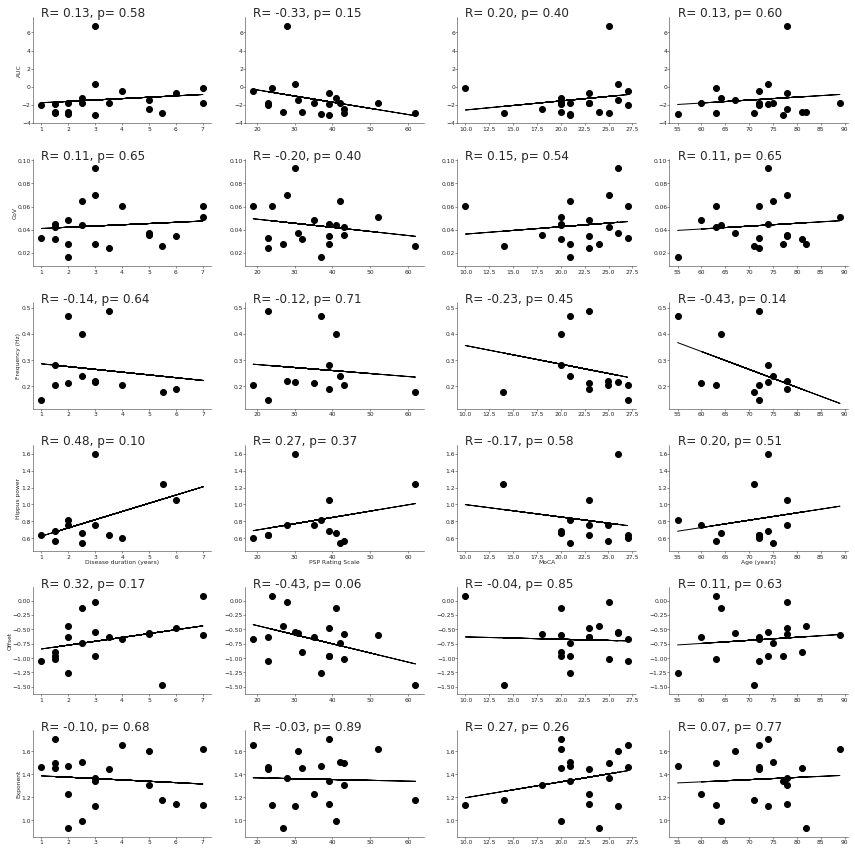

In [30]:
f, ax = plt.subplots(6, 4, figsize=(12, 12))
#f.suptitle('AUC ~ Clinical data')

cols = ['disease_duration', 'psp_rating_scale', 
        'MoCA', 'age']
rows = ['auc', 'cov', 'peak1_CF', 'peak1_PW', 'aperiodic_offset', 'aperiodic_exp']

d = label_dict

for i, col in enumerate(cols):
    for j, row in enumerate(rows):

        x = corr_data.loc[:, col].astype(float).values
        y = corr_data.loc[:, row].astype(float).values
        ax[j, i].scatter(x, y, color='black')
        
        mask = ~np.isnan(x) & ~np.isnan(y)
        slope, intercept, r, p, se = linregress(x[mask], y[mask])
        if p <.1:
            print(col, row, 'R2={0}, p={1}'.format(round(r*r, 2), round(p, 2)))
        ax[j, i].annotate('R= %.2f, p= %.2f' % (r,  p), xy=(x.min(),np.nanmax(y)+ (np.nanmax(y)-np.nanmin(y)) * .1))
        ax[j, i].plot(x, x*slope + intercept, marker='', lw=1, color='black')
        ax[j, i].set(xlabel=d[col],
              ylabel=d[row],
                    ylim = (np.nanmin(y)- (np.nanmax(y)-np.nanmin(y)) * .1,
                    np.nanmax(y)+ (np.nanmax(y)-np.nanmin(y)) * .1))
        


sns.despine()


           
        
for i, a in enumerate(ax):
    for j, axis in enumerate(a):
        if i == 3:
            continue
        else:
            axis.set(xlabel='')
  
        
for i, a in enumerate(ax):
    for j, axis in enumerate(a):
        if j == 0:
            continue
        else:
            axis.set(ylabel='')


f.tight_layout()

#f.savefig(join(edition, 'Figures', 'PUPIL_CLINICAL_PSP.png'), dpi=600)

## 1.2 GAIT ~ PUPIL all PSP

auc Velocity fast R2=0.26, p=0.05
auc Cadence normal R2=0.2, p=0.1
auc Cadence fast R2=0.26, p=0.05
auc Cadence turn R2=0.24, p=0.06
auc CycleTimemean fast R2=0.25, p=0.06
cov Velocity fast R2=0.26, p=0.05
cov Cadence normal R2=0.2, p=0.09
cov StepLengthSymmetryRatio normal R2=0.22, p=0.08
peak1_CF StepLengthSymmetryRatio fast R2=0.54, p=0.02
aperiodic_offset Velocity fast R2=0.22, p=0.08
aperiodic_offset Velocity turn R2=0.22, p=0.08
aperiodic_offset Cadence normal R2=0.25, p=0.06
aperiodic_offset Cadence turn R2=0.35, p=0.02
aperiodic_offset CycleTimemean normal R2=0.2, p=0.09


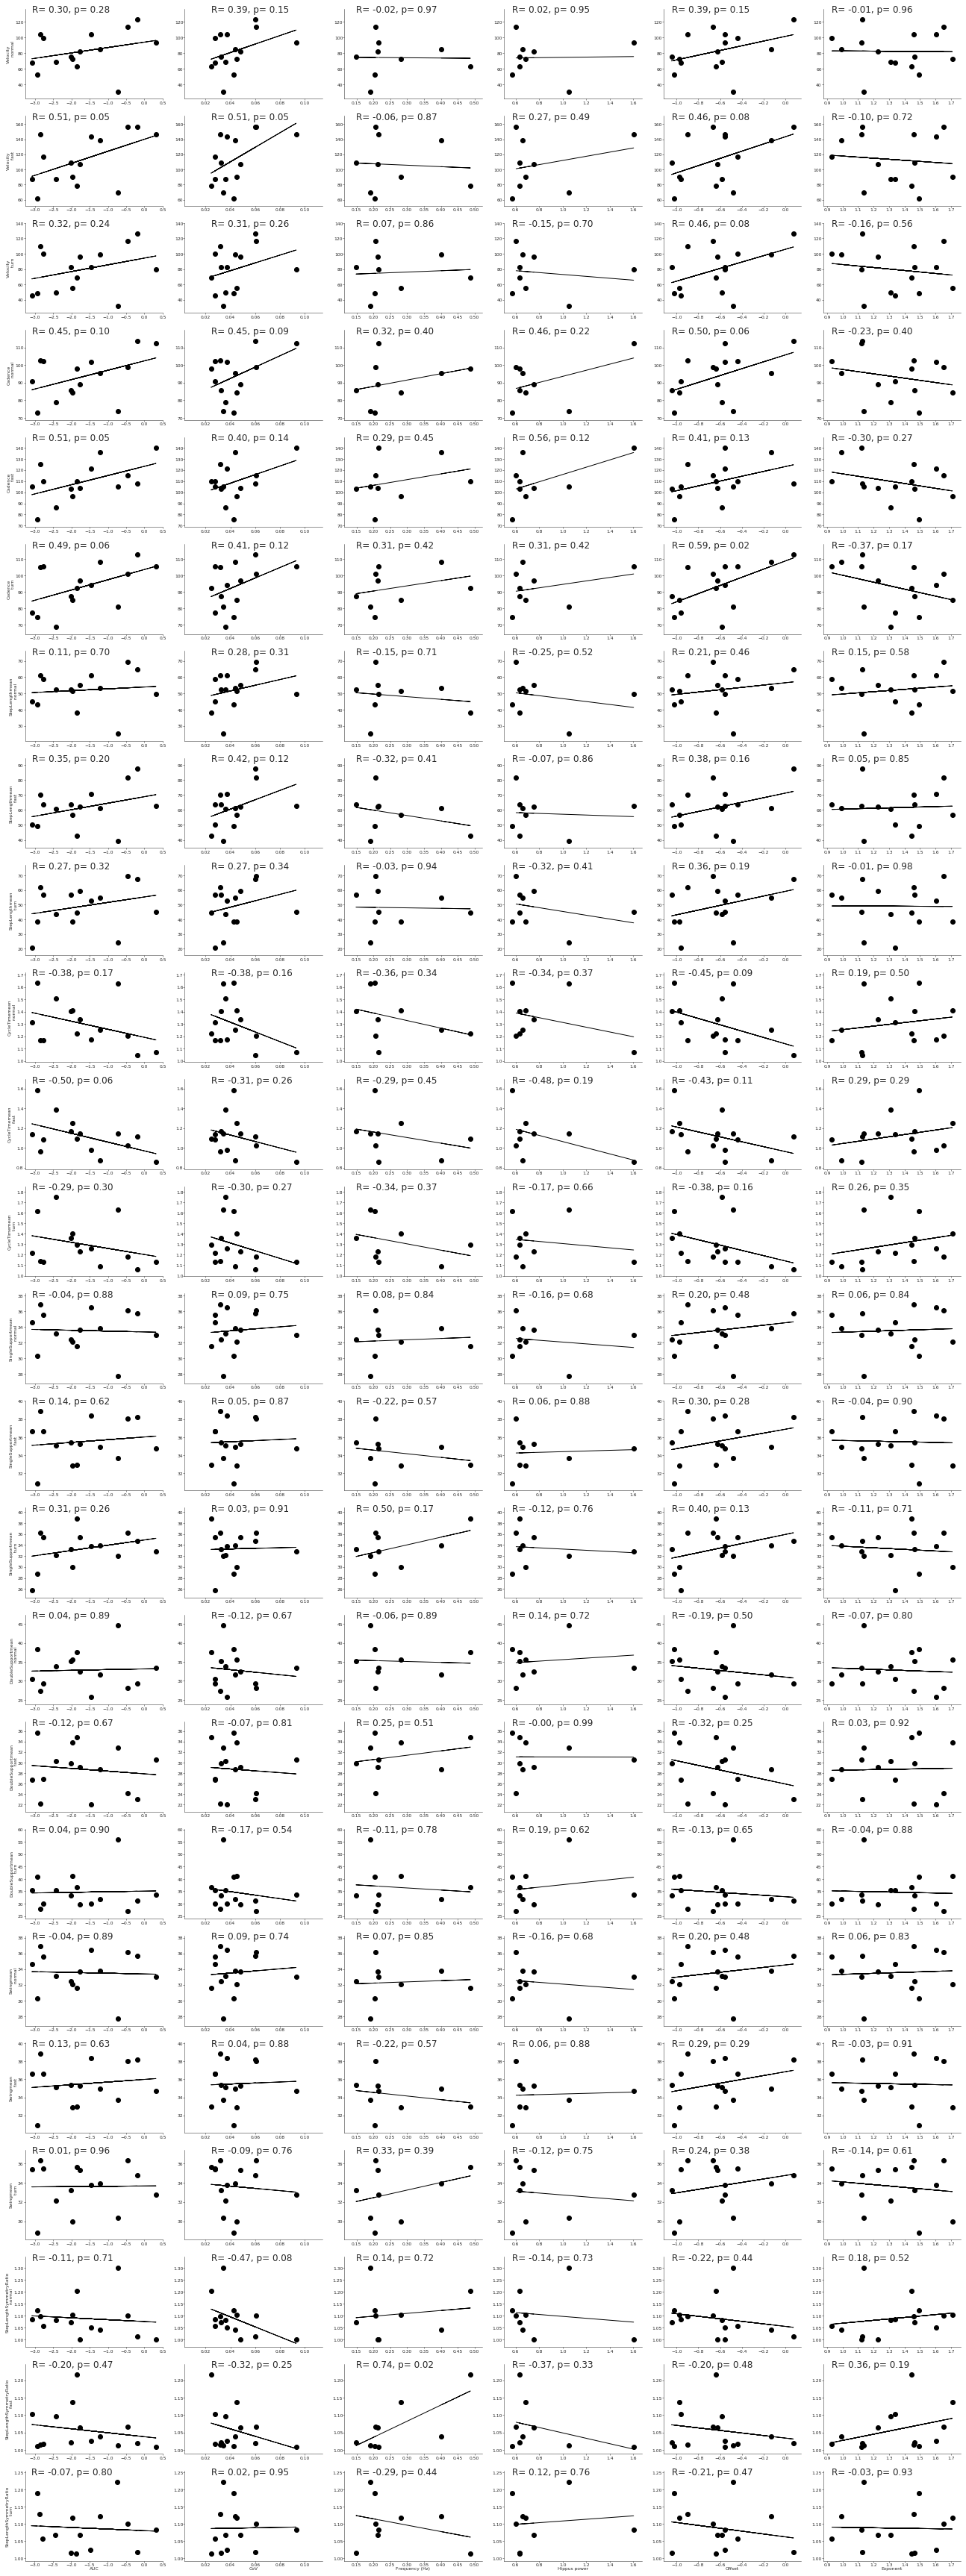

In [31]:
df = gcp.loc[gcp.group.isin(['vPSP', 'PSP-RS'])]

f, ax = plt.subplots(24, 6, figsize=(18, 48))
f.tight_layout()

pupil_parameters = ['auc', 'cov', 'peak1_CF', 'peak1_PW', 'aperiodic_offset', 'aperiodic_exp']

d = label_dict

gai = ['Velocity', 'Cadence', 'StepLengthmean', 'CycleTimemean', 
        'SingleSupportmean', 'DoubleSupportmean', 'Swingmean', 'StepLengthSymmetryRatio']
cond = ['normal', 'fast', 'turn']

for i, col in enumerate(pupil_parameters):
    for j, ro in enumerate(itertools.product(gai, cond)):

        x = df.loc[df.condition == ro[1], col].astype(float).values
        y = df.loc[df.condition == ro[1], ro[0]].astype(float).values
      
        ax[j, i].scatter(x, y, color='black')
        mask = ~np.isnan(x) & ~np.isnan(y)
        slope, intercept, r, p, se = linregress(x[mask], y[mask])
        if p <.1:
            print(col, ro[0], ro[1], 'R2={0}, p={1}'.format(round(r*r, 2), round(p, 2)))
        ax[j, i].annotate('R= %.2f, p= %.2f' % (r,  p), xy=(np.nanmin(x),np.nanmax(y)+ (np.nanmax(y)-np.nanmin(y)) * .1))
        ax[j, i].plot(x, x*slope + intercept, marker='', lw=1, color='black')
        ax[j, i].set(xlabel=d[col], ylabel='''{0}
        {1}'''.format(ro[0], ro[1]),
                    ylim=(np.nanmin(y) - (np.nanmax(y)-np.nanmin(y)) * .1, np.nanmax(y) + (np.nanmax(y)-np.nanmin(y)) * .15))


for i, a in enumerate(ax):
    for j, axis in enumerate(a):
        if i == 23:
            continue
        else:
            axis.set(xlabel='')
  
        
for i, a in enumerate(ax):
    for j, axis in enumerate(a):
        if j == 0:
            continue
        else:
            axis.set(ylabel='')
            

sns.despine()
#f.savefig(join(edition, 'Figures', 'GAIT_PUPIL_PSP.png'), dpi=600)

## 1.2.1 GAIT ~ PUpil just PSP-RS /// DEPRECATED

KeyError: 'CoV'

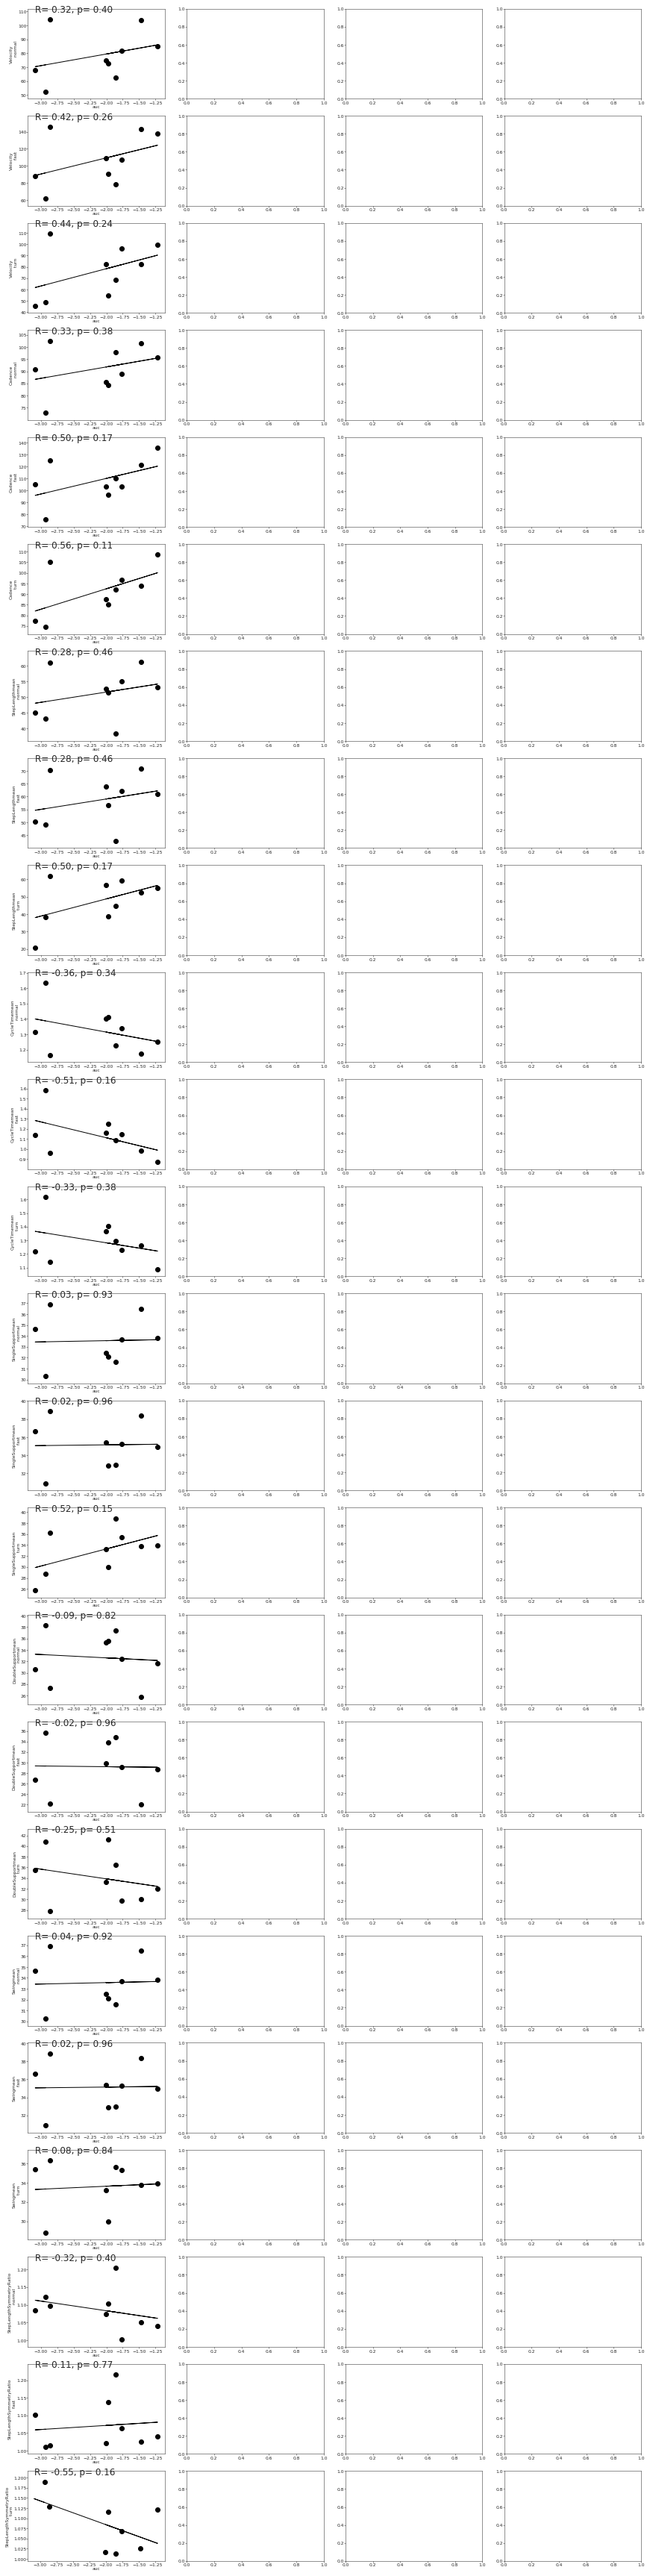

In [13]:
df = gcp.loc[gcp.group == 'PSP-RS']

f, ax = plt.subplots(24, 4, figsize=(12, 48))
f.tight_layout()

pupil_parameters = ['auc', 'CoV', 'offset', 'frequency']

cols = ['Velocity', 'Cadence', 'StepLengthmean', 'CycleTimemean', 
        'SingleSupportmean', 'DoubleSupportmean', 'Swingmean', 'StepLengthSymmetryRatio']
rows = ['normal', 'fast', 'turn']

for i, col in enumerate(pupil_parameters):
    for j, ro in enumerate(itertools.product(gai, cond)):

        x = df.loc[df.condition == ro[1], col].astype(float).values
        y = df.loc[df.condition == ro[1], ro[0]].astype(float).values
      
        ax[j, i].scatter(x, y, color='black')
        mask = ~np.isnan(x) & ~np.isnan(y)
        slope, intercept, r, p, se = linregress(x[mask], y[mask])
        if p <.1:
            print(col, ro[0], ro[1], 'R2={0}, p={1}'.format(round(r*r, 2), round(p, 2)))
        ax[j, i].annotate('R= %.2f, p= %.2f' % (r,  p), xy=(np.nanmin(x),np.nanmax(y)+ (np.nanmax(y)-np.nanmin(y)) * .1))
        ax[j, i].plot(x, x*slope + intercept, marker='', lw=1, color='black')
        ax[j, i].set(xlabel=col, ylabel='''{0}
        {1}'''.format(ro[0], ro[1]),
                    ylim=(np.nanmin(y) - (np.nanmax(y)-np.nanmin(y)) * .1, np.nanmax(y) + (np.nanmax(y)-np.nanmin(y)) * .15))
        if ro[0] == 'offset':
            ax[j, i].set(ylim=(0, 3))

for i, a in enumerate(ax):
    for j, axis in enumerate(a):
        if i == 11:
            continue
        else:
            axis.set(xlabel='')
  
        
for i, a in enumerate(ax):
    for j, axis in enumerate(a):
        if j == 0:
            continue
        else:
            axis.set(ylabel='')
            

sns.despine()
f.savefig(join(edition, 'Figures', 'GAIT_PUPIL_RS.png'), dpi=600)

## 1.2.2 GAIT ~ PUPIL vPSP /// DEPRECATED

NameError: name 'gai' is not defined

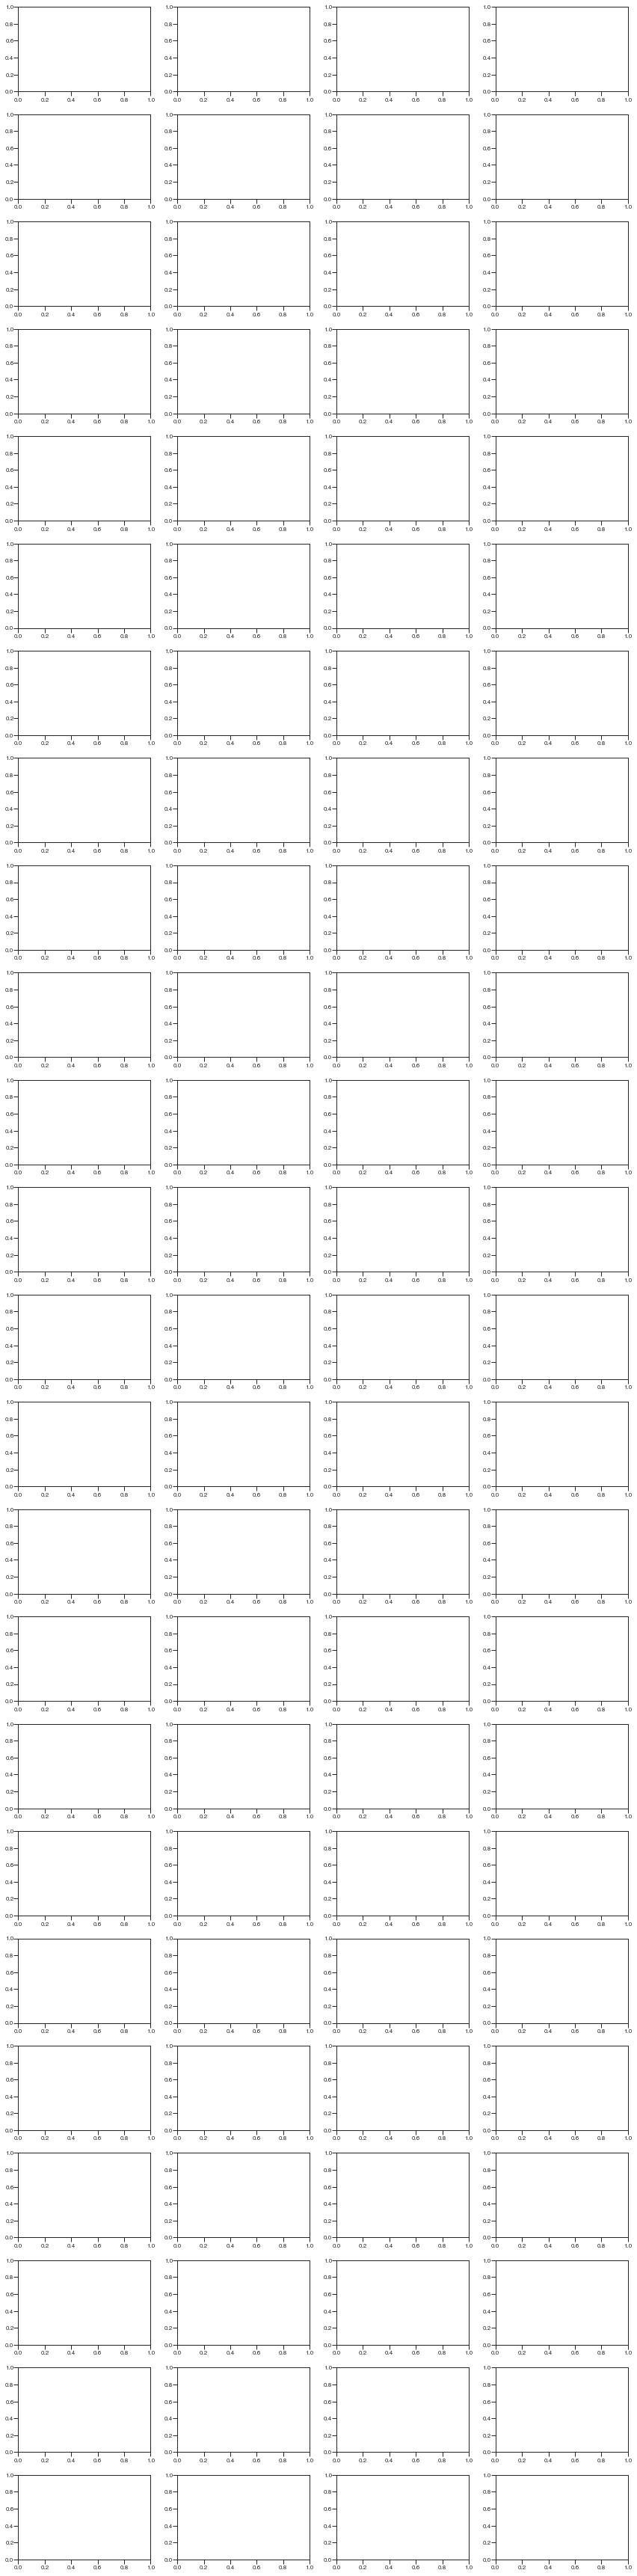

In [62]:
df = gcp.loc[gcp.group == 'vPSP']

f, ax = plt.subplots(24, 4, figsize=(12, 48))
f.tight_layout()

pupil_parameters = ['auc', 'CoV', 'offset', 'frequency']

cols = ['Velocity', 'Cadence', 'StepLengthmean', 'CycleTimemean', 
        'SingleSupportmean', 'DoubleSupportmean', 'Swingmean', 'StepLengthSymmetryRatio']
rows = ['normal', 'fast', 'turn']

for i, col in enumerate(pupil_parameters):
    for j, ro in enumerate(itertools.product(gai, cond)):

        x = df.loc[df.condition == ro[1], col].astype(float).values
        y = df.loc[df.condition == ro[1], ro[0]].astype(float).values
      
        ax[j, i].scatter(x, y, color='black')
        mask = ~np.isnan(x) & ~np.isnan(y)
        slope, intercept, r, p, se = linregress(x[mask], y[mask])
        if p <.1:
            print(col, ro[0], ro[1], 'R2={0}, p={1}'.format(round(r*r, 2), round(p, 2)))
        ax[j, i].annotate('R= %.2f, p= %.2f' % (r,  p), xy=(np.nanmin(x),np.nanmax(y)+ (np.nanmax(y)-np.nanmin(y)) * .1))
        ax[j, i].plot(x, x*slope + intercept, marker='', lw=1, color='black')
        ax[j, i].set(xlabel=col, ylabel='''{0}
        {1}'''.format(ro[0], ro[1]),
                    ylim=(np.nanmin(y) - (np.nanmax(y)-np.nanmin(y)) * .1, np.nanmax(y) + (np.nanmax(y)-np.nanmin(y)) * .15))
        if ro[0] == 'offset':
            ax[j, i].set(ylim=(0, 3))

for i, a in enumerate(ax):
    for j, axis in enumerate(a):
        if i == 11:
            continue
        else:
            axis.set(xlabel='')
  
        
for i, a in enumerate(ax):
    for j, axis in enumerate(a):
        if j == 0:
            continue
        else:
            axis.set(ylabel='')
            

sns.despine()
#f.savefig(join(edition, 'Figures', 'GAIT_PUPIL_vPSP.png'), dpi=600)

## 2.4 Correlations combined - just borderline significant

('disease_duration', 'peak1_PW', 0)
('psp_rating_scale', 'aperiodic_offset', 1)


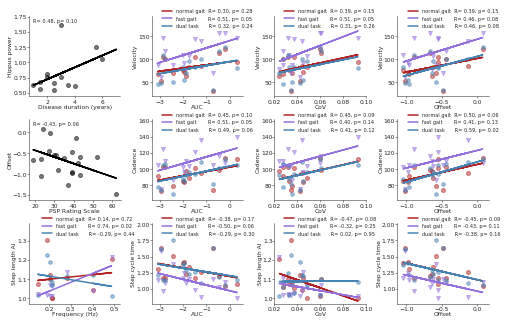

In [122]:
f, ax = plt.subplots(3, 4, figsize=(7, 4.5))
f.tight_layout()

df = gcp.loc[gcp.group.isin(['vPSP', 'PSP-RS'])]


lab = {'fast': 'fast gait',
      'normal': 'normal gait',
      'turn': 'dual task'}

#CLINICAL ~ PUPIL
for t in [('disease_duration', 'peak1_PW', 0),
          ('psp_rating_scale', 'aperiodic_offset', 1)]:
    print(t)
    x = corr_data.loc[:, t[0]].astype(float).values
    y = corr_data.loc[:, t[1]].astype(float).values
    ax[t[2],0].scatter(x, y, color='black', s=scatter_marker, alpha=.5)
    mask = ~np.isnan(x) & ~np.isnan(y)
    slope, intercept, r, p, se = linregress(x[mask], y[mask])
    ax[t[2],0].annotate('R= %.2f, p= %.2f' % (r,  p), xy=(np.nanmin(x),np.nanmax(y)+ (np.nanmax(y)-np.nanmin(y)) * .05), fontsize=psize)
    ax[t[2],0].plot(x, x*slope + intercept, marker='', lw=line_width_b, color='black')
    ax[t[2],0].set(xlabel=label_dict[t[0]],
          ylabel=label_dict[t[1]],
               ylim=(np.nanmin(y) - (np.nanmax(y)-np.nanmin(y)) * .1, np.nanmax(y) + (np.nanmax(y)-np.nanmin(y)) * .15))

#GAIT ~ PUPIL
for t in [('auc', 'Velocity', 1, 0),
('auc', 'Cadence', 1, 1),
('auc', 'CycleTimemean', 1, 2),
('cov', 'Velocity', 2, 0),
('cov', 'Cadence', 2, 1),
('cov', 'StepLengthSymmetryRatio', 2, 2),
('peak1_CF', 'StepLengthSymmetryRatio', 0, 2),
('aperiodic_offset', 'Velocity', 3, 0),
('aperiodic_offset', 'Cadence', 3, 1),
('aperiodic_offset', 'CycleTimemean', 3, 2)]:
    ym = df.loc[:, t[1]].values
    xm = df.loc[~df.Cadence.isnull()].loc[:, t[0]].values
    for c, color, di, m in zip(['normal',
                         'fast', 
                         'turn'], ['firebrick', 'mediumpurple', 'steelblue'], ['  ', '       ', '      '], ['o', 'v', 'h']):


        
        x = df.loc[df.condition == c, t[0]].astype(float).values
        y = df.loc[df.condition == c, t[1]].astype(float).values
        ax[t[3],t[2]].scatter(x, y, color=color, s=scatter_marker, alpha=.5, marker=m)
        mask = ~np.isnan(x) & ~np.isnan(y)
        slope, intercept, r, p, se = linregress(x[mask], y[mask])
        results = 'R= %.2f, p= %.2f' % (r,  p)
        ax[t[3],t[2]].plot(x, x*slope + intercept, marker='', lw=line_width_b, color=color, label = lab[c] + di + results)

    ax[t[3],t[2]].set(xlabel=label_dict[t[0]],
      ylabel=label_dict[t[1]],
           ylim=(np.nanmin(ym) - (np.nanmax(ym)-np.nanmin(ym)) * .1, np.nanmax(ym) + (np.nanmax(ym)-np.nanmin(ym)) * .3))

    ax[t[3],t[2]].legend(bbox_to_anchor=(np.nanmin(xm), np.nanmax(ym)+ (np.nanmax(ym)-np.nanmin(ym))*.25),
                   loc='center left', bbox_transform=ax[t[3],t[2]].transData, frameon=False, fontsize = psize)
    if t[0] == 'cov':
        ax[t[3],t[2]].set(xlim=(.02, .1))

sns.despine()
f.savefig(join(edition, 'Figures', 'CORRELATIONS_sig.png'), dpi=600)

## 2.4.1 Correlations combined - just borderline significant //// DEPRECATED

findfont: Font family ['HelveticaNeue'] not found. Falling back to DejaVu Sans.
findfont: Font family ['HelveticaNeue'] not found. Falling back to DejaVu Sans.


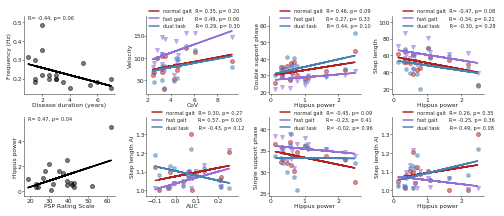

In [8]:
f, ax = plt.subplots(3, 4, figsize=(7, 4.5))
f.tight_layout()

df = gcp.loc[gcp.group.isin(['vPSP', 'PSP-RS'])]


d = {'disease_duration': 'Disease duration (years)', 
     'psp_rating_scale': 'PSP Rating Scale', 
        'MoCA': 'MoCA', 
     'age': 'Age (years)', 
     'auc': 'AUC', 
     'CoV': 'CoV', 
     'frequency': 'Frequency (Hz)', 
     'offset': 'Hippus power',
    'StepLengthSymmetryRatio':"Step length AI",
    'StepLengthmean': 'Step length',
    'DoubleSupportmean': 'Double support phase',
    'SingleSupportmean': 'Single support phase',
     'Velocity': 'Velocity'}

lab = {'fast': 'fast gait',
      'normal': 'normal gait',
      'turn': 'dual task'}

for t in [('CoV', 'Velocity', 0),
          ('auc', 'StepLengthSymmetryRatio', 1),
          ('offset', 'DoubleSupportmean', 2)

# disease duration ~ frequency
x = corr_data.loc[:, 'disease_duration'].astype(float).values
y = corr_data.loc[:, 'frequency'].astype(float).values
ax[0,0].scatter(x, y, color='black', s=scatter_marker, alpha=.5)
mask = ~np.isnan(x) & ~np.isnan(y)
slope, intercept, r, p, se = linregress(x[mask], y[mask])
ax[0,0].annotate('R= %.2f, p= %.2f' % (r,  p), xy=(x.min(),np.nanmax(y)+ (np.nanmax(y)-np.nanmin(y)) * .1), fontsize=psize)
ax[0,0].plot(x, x*slope + intercept, marker='', lw=line_width_b, color='black')
ax[0,0].set(xlabel=d['disease_duration'],
      ylabel=d['frequency'],
           ylim=(np.nanmin(y) - (np.nanmax(y)-np.nanmin(y)) * .1, np.nanmax(y) + (np.nanmax(y)-np.nanmin(y)) * .15))

# rating scale ~ offset
x = corr_data.loc[:, 'psp_rating_scale'].astype(float).values
y = corr_data.loc[:, 'offset'].astype(float).values
ax[1,0].scatter(x, y, color='black', s=scatter_marker, alpha=.5)
mask = ~np.isnan(x) & ~np.isnan(y)
slope, intercept, r, p, se = linregress(x[mask], y[mask])
ax[1,0].annotate('R= %.2f, p= %.2f' % (r,  p), xy=(x.min(),np.nanmax(y)+ (np.nanmax(y)-np.nanmin(y)) * .1), fontsize=psize)
ax[1,0].plot(x, x*slope + intercept, marker='', lw=line_width_b, color='black')
ax[1,0].set(xlabel=d['psp_rating_scale'],
      ylabel=d['offset'],
           ylim=(np.nanmin(y) - (np.nanmax(y)-np.nanmin(y)) * .1, np.nanmax(y) + (np.nanmax(y)-np.nanmin(y)) * .15))


#GAIT ~ PUPIL
for t in [('CoV', 'Velocity', 0 ,1),
          ('auc', 'StepLengthSymmetryRatio', 1 ,1),
          ('offset', 'DoubleSupportmean', 0 ,2),
          ('offset', 'SingleSupportmean', 1 ,2),
          ('offset', 'StepLengthmean', 0 ,3),
          ('offset', 'StepLengthSymmetryRatio', 1 ,3)
         ]:
    for c, color, di, m in zip(['normal',
                         'fast', 
                         'turn'], ['firebrick', 'mediumpurple', 'steelblue'], ['  ', '       ', '      '], ['o', 'v', 'h']):


        ym = df.loc[:, t[1]].values
        x = df.loc[df.condition == c, t[0]].astype(float).values
        y = df.loc[df.condition == c, t[1]].astype(float).values
        ax[t[2],t[3]].scatter(x, y, color=color, s=scatter_marker, alpha=.5, marker=m)
        mask = ~np.isnan(x) & ~np.isnan(y)
        slope, intercept, r, p, se = linregress(x[mask], y[mask])
        results = 'R= %.2f, p= %.2f' % (r,  p)
        ax[t[2],t[3]].plot(x, x*slope + intercept, marker='', lw=line_width_b, color=color, label = lab[c] + di + results)

    ax[t[2],t[3]].set(xlabel=d[t[0]],
      ylabel=d[t[1]],
           ylim=(np.nanmin(ym) - (np.nanmax(ym)-np.nanmin(ym)) * .1, np.nanmax(ym) + (np.nanmax(ym)-np.nanmin(ym)) * .3))

    ax[t[2],t[3]].legend(bbox_to_anchor=(np.nanmin(df.loc[:, t[0]].values), np.nanmax(ym)+ (np.nanmax(ym)-np.nanmin(ym))*.25),
                   loc='center left', bbox_transform=ax[t[2],t[3]].transData, frameon=False, fontsize = psize)


sns.despine()
#f.savefig(join(edition, 'Figures', 'CORRELATIONS_sig.png'), dpi=600)

## 2. Tables

## 2.1 GAIT vPSP vs. PSP-RS vs. HC vs. PD

In [28]:
cols = ['Velocity', 'Cadence', 'StepLengthmean',
       'CycleTimemean', 'SingleSupportmean', 'DoubleSupportmean', 'Swingmean', 'StepLengthSymmetryRatio']

mean = gcp.loc[~gcp.Velocity.isnull()].groupby(['condition', 'group']).mean().loc[:, cols].T
std = gcp.loc[~gcp.Velocity.isnull()].groupby(['condition', 'group']).std().loc[:, cols].T

for condition in ['fast', 'normal', 'turn']:
    for param in mean.index:
        samples = [gcp.loc[(gcp.condition == condition) & (gcp.group == 'PSP-RS'), param].values,
                    gcp.loc[(gcp.condition == condition) & (gcp.group == 'vPSP'), param].values,
                    gcp.loc[(gcp.condition == condition) & (gcp.group == 'PD'), param].values,
                    gcp.loc[(gcp.condition == condition) & (gcp.group == 'HC'), param].values]
        anova = f_oneway(samples[0],samples[1],samples[2],samples[3])
        if anova[1]<0.05:
            print(condition, param)
        mean.loc[param, (condition, 'F')] = anova[0]
        mean.loc[param, (condition, 'p_value')] = anova[1]
        mean.loc[param, (condition, 't_test_RS_vPSP')] = ttest_ind(gcp.loc[(gcp.condition == condition) & (gcp.group == 'PSP-RS'), param].values,
                    gcp.loc[(gcp.condition == condition) & (gcp.group == 'vPSP'), param].values)[1]

fast Velocity
fast Cadence
fast StepLengthmean
fast CycleTimemean
fast SingleSupportmean
fast DoubleSupportmean
fast Swingmean
normal Velocity
normal Cadence
normal StepLengthmean
normal CycleTimemean
normal SingleSupportmean
normal DoubleSupportmean
normal Swingmean
turn Cadence
turn Swingmean


In [58]:
gcp.loc[gcp.StepLengthSymmetryRatio.isnull()].loc[105]

index                              1
subject                            2
condition                       turn
Velocity                        45.9
Cadence                         77.4
StepLengthmean                 20.56
CycleTimemean                 1.2175
SingleSupportmean              25.76
DoubleSupportmean             35.475
Swingmean                      35.35
StepLengthSymmetryRatio          NaN
Geschlecht                         m
age                               77
disease_duration                   3
Subtypen                      PSP-RS
psp_rating_scale                  39
MoCA                              21
session                     Baseline
auc                         -3.08805
session                     Baseline
mean                         42.7669
std                          1.17497
cov                        0.0274738
session                     Baseline
aperiodic_offset           -0.957885
aperiodic_knee               1.33882
aperiodic_exp                1.33882
n

In [56]:
gcp.loc[95]

index                            43
subject                      IPS 12
condition                      fast
Velocity                    134.033
Cadence                     142.167
StepLengthmean              56.6483
CycleTimemean              0.843333
SingleSupportmean              34.2
DoubleSupportmean           31.5833
Swingmean                      34.2
StepLengthSymmetryRatio     1.06985
Geschlecht                      NaN
age                             NaN
disease_duration                NaN
Subtypen                        NaN
psp_rating_scale                NaN
MoCA                            NaN
session                         NaN
auc                             NaN
session                         NaN
mean                            NaN
std                             NaN
cov                             NaN
session                         NaN
aperiodic_offset                NaN
aperiodic_knee                  NaN
aperiodic_exp                   NaN
n_peaks                     

In [50]:
gcp.loc[~gcp.StepLengthSymmetryRatio.isnull()]

,index,subject,condition,Velocity,Cadence,StepLengthmean,CycleTimemean,SingleSupportmean,DoubleSupportmean,Swingmean,...,peak2_CF,peak2_PW,peak2_BW,peak3_CF,peak3_PW,peak3_BW,R2,error,RS,group
0,0,1,normal,52.600000,73.000000,43.065000,1.633333,30.316667,38.316667,30.266667,...,NaN,NaN,NaN,NaN,NaN,NaN,0.946106,0.117599,True,PSP-RS
1,1,2,normal,68.000000,90.766667,44.905000,1.313333,34.633333,30.550000,34.633333,...,NaN,NaN,NaN,NaN,NaN,NaN,0.923083,0.119967,True,PSP-RS
2,2,3,normal,99.533333,102.166667,58.641667,1.165000,35.550000,29.216667,35.550000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.856657,0.108651,False,vPSP
3,3,6,normal,30.900000,73.866667,25.163333,1.626667,27.750000,44.600000,27.716667,...,0.266357,0.692554,0.130657,NaN,NaN,NaN,0.953848,0.106718,False,vPSP
4,4,7,normal,104.133333,102.566667,60.878333,1.165000,36.900000,27.283333,36.883333,...,NaN,NaN,NaN,NaN,NaN,NaN,0.935658,0.108859,True,PSP-RS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,42,IPS 11,turn,121.466667,101.400000,71.760000,1.175000,36.883333,26.233333,36.866667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PD
147,43,IPS 12,turn,46.066667,139.700000,19.820000,0.860000,23.966667,50.933333,24.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PD
148,44,IPS 13,turn,84.866667,106.233333,48.158333,1.131667,31.433333,37.133333,31.433333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PD
149,45,IPS 14,turn,59.733333,151.233333,23.693333,0.793333,26.716667,46.583333,26.733333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PD


In [31]:
print('mean')
mean.loc['Velocity']

mean


condition  group         
fast       HC                2.048314e+02
           PD                1.444922e+02
           PSP-RS            1.069926e+02
           vPSP              1.221167e+02
normal     HC                1.390333e+02
           PD                1.004822e+02
           PSP-RS            7.836296e+01
           vPSP              8.815556e+01
turn       HC                9.845196e+01
           PD                7.999889e+01
           PSP-RS            7.642593e+01
           vPSP              8.408889e+01
fast       F                 2.144940e+01
           p_value           1.198960e-08
           t_test_RS_vPSP    4.025718e-01
normal     F                 1.772841e+01
           p_value           1.224120e-07
           t_test_RS_vPSP    4.702563e-01
turn       F                 2.062425e+00
           p_value           1.193209e-01
           t_test_RS_vPSP    6.296194e-01
Name: Velocity, dtype: float64

In [10]:
print('std')
std

std


condition                     fast                                   \
group                           HC         PD     PSP-RS       vPSP   
Velocity                 29.887494  36.713666  30.248098  37.358544   
Cadence                  17.000806  20.402449  17.707391  17.516360   
StepLengthmean            7.049067  15.145545   9.619830  16.949061   
CycleTimemean             0.101236   0.149811   0.206307   0.171725   
SingleSupportmean         2.597480   3.279900   2.606346   1.849817   
DoubleSupportmean         5.476246   6.684426   5.034047   3.866705   
Swingmean                 2.599265   3.286815   2.615359   1.840401   
StepLengthSymmetryRatio   0.025139   0.081106   0.069469   0.036095   

condition                   normal                                   \
group                           HC         PD     PSP-RS       vPSP   
Velocity                 15.147552  27.288320  17.455932  33.690907   
Cadence                   6.821519  12.942669   9.441928  16.846792   
StepLengthmean            5.756055  12.559471   7.809327  15.651979   
CycleTimemean             0.066951   0.147041   0.147203   0.240589   
SingleSupportmean         1.584490   2.247300   2.196753   3.147246   
DoubleSupportmean         3.111840   4.488527   4.380128   6.114297   
Swingmean                 1.589997   2.250065   2.204532   3.164328   
StepLengthSymmetryRatio   0.022198   0.075385   0.057330   0.109253   

condition                     turn                                   
group                           HC         PD     PSP-RS       vPSP  
Velocity                 22.580367  24.566459  23.226367  37.283399  
Cadence                  12.600593  24.457878  11.483141  17.104511  
StepLengthmean           10.211933  14.713257  13.258536  17.038605  
CycleTimemean             0.127775   0.425226   0.157193   0.295508  
SingleSupportmean         2.935261   7.105752   4.035724   1.815634  
DoubleSupportmean         7.324049  11.478198   4.791790  10.437085  
Swingmean                 2.918627   5.133738   2.573031   2.245481  
StepLengthSymmetryRatio   0.134824   0.132335   0.064461   0.070145

## 2.2 Clinical RS vs. vPSP

In [33]:
# Make a table with clinical characteristics and t-test between RS and vPSP


clinical_RS = clinical_df.loc[:, ['age', 'Geschlecht', 'subject', 'psp_rating_scale', 'MoCA', 'RS', 'disease_duration']].groupby('RS').mean().T
clinical_RS.columns = [clinical_RS.columns, ['mean', 'mean']]

clinical_RS_2 = clinical_df.loc[:, ['age', 'Geschlecht', 'subject', 'psp_rating_scale', 'MoCA', 'RS', 'disease_duration']].groupby('RS').std().T
clinical_RS_2.columns = [clinical_RS_2.columns, ['std', 'std']]

clinical_RS = pd.concat([clinical_RS, clinical_RS_2], axis=1)
clinical_RS['p_value'] = np.nan

for i in ['age', 'psp_rating_scale', 'MoCA', 'disease_duration']:
    clinical_RS.loc[i, ['p_value']]  = ttest_ind(clinical_df.loc[clinical_df.RS == True, i].values, clinical_df.loc[clinical_df.RS != True, i].values)[1]

In [34]:
clinical_RS

RS,False,True,False,True,p_value
,mean,mean,std,std,
age,74.500000,71.285714,6.625708,8.947957,0.441394
psp_rating_scale,30.333333,37.642857,9.114092,10.623683,0.160225
MoCA,21.333333,21.857143,6.377042,3.324898,0.809626
disease_duration,4.500000,2.964286,1.870829,1.748233,0.094519


## Example ANOVA

### one way ANOVA (no repeated measures)

Voraussetzungen:

1. independence
2. Variances equal (not significantly different)
3. Normal verteilt

In [35]:
# 5 subjects do not have GAIT data
print('no gait data for', gcp.loc[gcp.Velocity.isnull()].subject.unique()) # -> exclude these

df = gcp.loc[~gcp.Velocity.isnull()]




no gait data for ['14' '18' '23' '25' '26']


In [36]:
y = df.loc[df.condition == 'normal']['Velocity']
x = df.loc[df.condition == 'normal']['group']

In [37]:
# 1. RUN ANOVA with statsmodel

model = ols('Velocity ~ C(group)', data=df.loc[df.condition == 'normal']).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(group),27470.010887,3.0,17.728411,1.224120e-07
Residual,22209.369380,43.0,NaN,NaN


In [38]:
aov_table['PR(>F)'][0]

1.2241201239586092e-07

In [39]:
# 2. Check assumpotions. 2.1 Check e.g. with shapiros test for normality

stats.shapiro(model.resid)

ShapiroResult(statistic=0.9853790998458862, pvalue=0.8156834244728088)

The test is non-significant, which indicates that the residuals are normally distributed.

In [40]:
# 2.2 check e.g. with Levenes test for homogeneity of variances

stats.levene(df.loc[(df.condition == 'normal')&(df.group == 'PSP-RS')]['Velocity'],
            df.loc[(df.condition == 'normal')&(df.group == 'vPSP')]['Velocity'],
            df.loc[(df.condition == 'normal')&(df.group == 'PD')]['Velocity'],
            df.loc[(df.condition == 'normal')&(df.group == 'HC')]['Velocity'])
    


LeveneResult(statistic=1.783232639016664, pvalue=0.16464264404350443)

The Levene's test of homogeneity of variances is not significant which indicates that the groups have non-statistically significant difference in their varability.

In [41]:
# 3. Run post-hoc (theroretically also t-test works)

comp = mc.MultiComparison(y, x)
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
HC,PD,-38.5511,0.001,-60.0677,-17.0345,True
HC,PSP-RS,-60.6704,0.001,-85.709,-35.6318,True
HC,vPSP,-50.8778,0.001,-79.7203,-22.0353,True
PD,PSP-RS,-22.1193,0.1121,-47.7291,3.4906,False
PD,vPSP,-12.3267,0.659,-41.6665,17.0131,False
PSP-RS,vPSP,9.7926,0.8279,-22.2198,41.8049,False


In [75]:
cols = ['Velocity', 'Cadence', 'StepLengthmean',
       'CycleTimemean', 'SingleSupportmean', 'DoubleSupportmean', 'Swingmean', 'StepLengthSymmetryRatio']

data = gcp.loc[~gcp.Velocity.isnull()]

mean = data.groupby(['condition', 'group']).mean().loc[:, cols].T
std = data.groupby(['condition', 'group']).std().loc[:, cols].T

for condition in ['fast', 'normal', 'turn']:
    for param in mean.index:
        psp_rs = data.loc[(data.condition == condition) & (data.group == 'PSP-RS'), param].values
        if param == 'StepLengthSymmetryRatio':
            psp_rs = psp_rs[~np.isnan(psp_rs)] # there is one PSPRS that has NaN as step length symmetry ratio
        vpsp = data.loc[(data.condition == condition) & (data.group == 'vPSP'), param].values
        PD = data.loc[(data.condition == condition) & (data.group == 'PD'), param].values
        hc = data.loc[(data.condition == condition) & (data.group == 'HC'), param].values
        
        model = ols('{0} ~ C(group)'.format(param), data=data.loc[data.condition == condition]).fit()
        aov_table = sm.stats.anova_lm(model, typ=2)
        F = aov_table['F'][0]
        ANOVA_p = aov_table['PR(>F)'][0]
        levene_p = stats.levene(psp_rs, vpsp, PD, hc)[1]
        shapiro_p = stats.shapiro(model.resid)[1]
        
        comp = mc.MultiComparison(data.loc[data.condition == condition, param].values, data.loc[data.condition == condition, 'group'].values)
        post_hoc_res = comp.tukeyhsd()
        tukey = pd.read_html(post_hoc_res.summary().as_html(), header=0)[0]
              
        
        mean.loc[param, (condition, 'F')] = F
        mean.loc[param, (condition, 'ANOVA_p')] = ANOVA_p
        mean.loc[param, (condition, 'levene_p')] = levene_p
        mean.loc[param, (condition, 'shapiro_p')] = shapiro_p
        
        for combo in itertools.combinations(gcp.group.unique(), 2): 
            
            try:
                mean.loc[param, (condition, 'tukey_{0}_{1}'.format(combo[0], combo[1]))] =\
                tukey.loc[(tukey.group2 == combo[0])&(tukey.group1 == combo[1])]['p-adj'].values[0]
                
                
                
            except IndexError:
                mean.loc[param, (condition, 'tukey_{0}_{1}'.format(combo[0], combo[1]))] =\
                tukey.loc[(tukey.group1 == combo[0])&(tukey.group2 == combo[1])]['p-adj'].values[0]                
            


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.


In [76]:
mean.stack('condition')

group                                   ANOVA_p          F          HC  \
                        condition                                        
Velocity                fast       1.198960e-08  21.449397  204.831373   
                        normal     1.224120e-07  17.728411  139.033333   
                        turn       1.193209e-01   2.062425   98.451961   
Cadence                 fast       1.333206e-04   8.638102  141.773529   
                        normal     2.012519e-04   8.186501  110.918627   
                        turn       3.267632e-02   3.198174  111.592157   
StepLengthmean          fast       1.578044e-06  14.066975   86.745618   
                        normal     2.600359e-07  16.604533   75.115667   
                        turn       6.632195e-01   0.531333   52.004221   
CycleTimemean           fast       9.148125e-05   9.058330    0.850010   
                        normal     2.628603e-04   7.897933    1.077181   
                        turn       2.467219e-01   1.431521    1.096000   
SingleSupportmean       fast       3.137453e-05  10.291305   40.822059   
                        normal     1.768157e-05  10.976646   37.662745   
                        turn       2.305943e-01   1.490496   36.329412   
DoubleSupportmean       fast       5.376220e-06  12.457078   16.958333   
                        normal     3.480091e-06  13.018069   24.107843   
                        turn       1.934498e-01   1.643298   32.030392   
Swingmean               fast       3.239931e-05  10.253412   40.816667   
                        normal     1.927219e-05  10.872575   37.658333   
                        turn       4.710251e-02   2.874220   36.328431   
StepLengthSymmetryRatio fast       2.660080e-01   1.365713    1.028560   
                        normal     8.803168e-02   2.326662    1.030606   
                        turn       7.028493e-01   0.472831    1.138215   

group                                      PD      PSP-RS  levene_p  \
                        condition                                     
Velocity                fast       144.492222  106.992593  0.679060   
                        normal     100.482222   78.362963  0.164643   
                        turn        79.998889   76.425926  0.341027   
Cadence                 fast       132.045556  108.351852  0.926481   
                        normal     109.118889   91.177778  0.106821   
                        turn       107.202222   91.251852  0.391175   
StepLengthmean          fast        66.130111   58.540000  0.091951   
                        normal      54.969389   51.139815  0.025988   
                        turn        46.613000   47.506481  0.475441   
CycleTimemean           fast         0.926444    1.132593  0.575137   
                        normal       1.115889    1.324074  0.062511   
                        turn         1.215111    1.291204  0.539164   
SingleSupportmean       fast        37.395556   35.137037  0.774250   
                        normal      34.421667   33.548148  0.348649   
                        turn        33.320000   32.877037  0.312271   
DoubleSupportmean       fast        25.511667   29.219444  0.810660   
                        normal      31.297222   32.685185  0.390695   
                        turn        38.956111   34.086111  0.513295   
Swingmean               fast        37.397222   35.136111  0.764805   
                        normal      34.422222   33.548148  0.353522   
                        turn        32.672222   33.588889  0.211624   
StepLengthSymmetryRatio fast         1.061049    1.070009  0.321867   
                        normal       1.066227    1.086693  0.060525   
                        turn         1.114043    1.084725  0.629586   

group                                 shapiro_p  tukey_HC_PD  tukey_PSP-RS_HC  \
                        condition                                               
Velocity                fast       5.174700e-02       0.0010      

In [77]:
stacked = mean.stack('condition')


In [78]:
def smaller_than(value):
    logs=np.append(np.logspace(-15, 1, 17), .05)
    sorteds=np.sort(np.append(logs, value))
    index=np.where(sorteds==value)[0]
    return sorteds[index+1][0]

def p_annot(p_value, dec):
    10**-3
    if p_value < 10**-dec:
        text = '<{0}'.format(smaller_than(p_value))
    else:
        text = '{}'.format(np.round(p_value, dec))
    return text

stacked = mean.stack('condition')

for i in std.stack('condition').index:
    for group in ['HC', 'vPSP', 'PSP-RS', 'PD']:
        if i[0] == 'StepLengthSymmetryRatio':
            
            stacked.loc[i, group] = '{0} ± {1}'.format(np.round(stacked.loc[i, group], decimals=2), np.round(std.stack('condition').loc[i, group], decimals=2))
        else:
            stacked.loc[i, group] = '{0} ± {1}'.format(np.round(stacked.loc[i, group], decimals=1), np.round(std.stack('condition').loc[i, group], decimals=1))            
    stacked.loc[i, 'F'] = p_annot(stacked.loc[i, 'F'], dec=2) 
    for c in ['ANOVA_p', 'levene_p', 'shapiro_p', 'tukey_PSP-RS_vPSP', 'tukey_PSP-RS_PD', 'tukey_vPSP_PD', 'tukey_PSP-RS_HC', 'tukey_vPSP_HC']:        
        stacked.loc[i, c] = p_annot(stacked.loc[i, c], dec=3) 






In [79]:
cols = ['PSP-RS', 'vPSP', 'PD', 'HC', 'F', 'ANOVA_p', 'levene_p', 'shapiro_p', 'tukey_PSP-RS_vPSP', 'tukey_PSP-RS_PD', 'tukey_vPSP_PD', 'tukey_PSP-RS_HC', 'tukey_vPSP_HC']
stacked.loc[:, cols].astype(str).to_csv(join(edition, 'Figures', 'data', 'GAIT_table.csv'), sep = ',')

In [80]:
stacked['tukey_PSP-RS_vPSP'].values

stacked= stacked.loc[:, cols]

In [81]:
d = stacked.reset_index().T.reset_index().T

from docx import Document
doc = Document()
t = doc.add_table(rows=d.shape[0], cols=d.shape[1])

for i in range(d.shape[0]):
    for j in range(d.shape[1]):
        cell = d.iat[i, j]
        t.cell(i, j).text = str(cell)

doc.save(join(edition, 'Figures', 'data', 'Gait_table.docx'))

In [82]:
stacked

group                                    PSP-RS          vPSP            PD  \
                        condition                                             
Velocity                fast       107.0 ± 30.2  122.1 ± 37.4  144.5 ± 36.7   
                        normal      78.4 ± 17.5   88.2 ± 33.7  100.5 ± 27.3   
                        turn        76.4 ± 23.2   84.1 ± 37.3   80.0 ± 24.6   
Cadence                 fast       108.4 ± 17.7  110.7 ± 17.5  132.0 ± 20.4   
                        normal       91.2 ± 9.4   96.7 ± 16.8  109.1 ± 12.9   
                        turn        91.3 ± 11.5   95.8 ± 17.1  107.2 ± 24.5   
StepLengthmean          fast         58.5 ± 9.6   65.9 ± 16.9   66.1 ± 15.1   
                        normal       51.1 ± 7.8   53.3 ± 15.7   55.0 ± 12.6   
                        turn        47.5 ± 13.3   51.1 ± 17.0   46.6 ± 14.7   
CycleTimemean           fast          1.1 ± 0.2     1.1 ± 0.2     0.9 ± 0.1   
                        normal        1.3 ± 0.1     1.3 ± 0.2     1.1 ± 0.1   
                        turn          1.3 ± 0.2     1.3 ± 0.3     1.2 ± 0.4   
SingleSupportmean       fast         35.1 ± 2.6    36.1 ± 1.8    37.4 ± 3.3   
                        normal       33.5 ± 2.2    33.6 ± 3.1    34.4 ± 2.2   
                        turn         32.9 ± 4.0    33.9 ± 1.8    33.3 ± 7.1   
DoubleSupportmean       fast         29.2 ± 5.0    28.0 ± 3.9    25.5 ± 6.7   
                        normal       32.7 ± 4.4    33.1 ± 6.1    31.3 ± 4.5   
                        turn         34.1 ± 4.8   35.5 ± 10.4   39.0 ± 11.5   
Swingmean               fast         35.1 ± 2.6    36.1 ± 1.8    37.4 ± 3.3   
                        normal       33.5 ± 2.2    33.6 ± 3.2    34.4 ± 2.3   
                        turn         33.6 ± 2.6    33.6 ± 2.2    32.7 ± 5.1   
StepLengthSymmetryRatio fast        1.07 ± 0.07   1.04 ± 0.04   1.06 ± 0.08   
                        normal      1.09 ± 0.06   1.09 ± 0.11   1.07 ± 0.08   
                        turn        1.08 ± 0.06   1.09 ± 0.07   1.11 ± 0.13   

group                                        HC      F  ANOVA_p levene_p  \
                        condition                                          
Velocity                fast       204.8 ± 29.9  21.45   <1e-07    0.679   
                        normal     139.0 ± 15.1  17.73   <1e-06    0.165   
                        turn        98.5 ± 22.6   2.06    0.119    0.341   
Cadence                 fast       141.8 ± 17.0   8.64   <0.001    0.926   
                        normal      110.9 ± 6.8   8.19   <0.001    0.107   
                        turn       111.6 ± 12.6    3.2    0.033    0.391   
StepLengthmean          fast         86.7 ± 7.0  14.07   <1e-05    0.092   
                        normal       75.1 ± 5.8   16.6   <1e-06    0.026   
                        turn        52.0 ± 10.2   0.53    0.663    0.475   
CycleTimemean           fast          0.9 ± 0.1   9.06  <0.0001    0.575   
                        normal        1.1 ± 0.1    7.9   <0.001    0.063   
                        turn          1.1 ± 0.1   1.43    0.247    0.539   
SingleSupportmean       fast         40.8 ± 2.6  10.29  <0.0001    0.774   
                        normal       37.7 ± 1.6  10.98  <0.0001    0.349   
                        turn         36.3 ± 2.9   1.49    0.231    0.312   
DoubleSupportmean       fast         17.0 ± 5.5  12.46   <1e-05    0.811   
                        normal       24.1 ± 3.1  13.02   <1e-05    0.391   
                        turn         32.0 ± 7.3   1.64    0.193    0.513   
Swingmean               fast         40.8 ± 2.6  10.25  <0.0001    0.765   
                        normal       37.7 ± 1.6  10.87  <0.0001    0.354   
                        turn         36.3 ± 2.9   2.87    0.047    0.212   
StepLengthSymmetryRatio fast        1.03 ± 0.03   1.37    0.266    0.322   
                        normal      1.03 ± 0.02   2.33    0.088    0.061   
                        turn        1.14 ± 0.

In [10]:
gcp.loc[gcp.Velocity.isnull()]

,index,subject,condition,Velocity,Cadence,StepLengthmean,CycleTimemean,SingleSupportmean,DoubleSupportmean,Swingmean,...,auc,frequency,offset,hippus_power,session,mean,std,CoV,RS,group
47,47,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.244441,0.166667,5.192533,NaN,Baseline,41.802313,1.084513,2.599643,True,PSP-RS
48,48,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001319,0.150000,0.448305,NaN,Baseline,49.175055,2.530088,5.146957,True,PSP-RS
49,49,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.131842,0.200000,0.533892,NaN,Baseline,62.472978,4.119435,6.622725,True,PSP-RS
50,50,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.024889,0.200000,1.598439,NaN,Baseline,90.312601,6.066538,6.757917,True,PSP-RS
51,51,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.151573,0.483333,1.459512,NaN,Baseline,71.475120,1.247727,1.745872,True,PSP-RS
99,47,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.244441,0.166667,5.192533,NaN,Baseline,41.802313,1.084513,2.599643,True,PSP-RS
100,48,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001319,0.150000,0.448305,NaN,Baseline,49.175055,2.530088,5.146957,True,PSP-RS
101,49,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.131842,0.200000,0.533892,NaN,Baseline,62.472978,4.119435,6.622725,True,PSP-RS
102,50,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.024889,0.200000,1.598439,NaN,Baseline,90.312601,6.066538,6.757917,True,PSP-RS
103,51,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.151573,0.483333,1.459512,NaN,Baseline,71.475120,1.247727,1.745872,True,PSP-RS


In [16]:
pat_data.disease_duration = pat_data.disease_duration.astype(float)
pat_data.median()

subject             15.0
age                 73.0
disease_duration     3.0
psp_rating_scale    36.0
MoCA                22.0
dtype: float64

In [19]:
pat_data.quantile(0.25)

subject              8.50
age                 66.25
disease_duration     2.00
psp_rating_scale    27.75
MoCA                20.00
Name: 0.25, dtype: float64

In [20]:
pat_data.quantile(0.75)

subject             21.25
age                 78.00
disease_duration     5.00
psp_rating_scale    41.25
MoCA                25.00
Name: 0.75, dtype: float64

## 2. Measures for text

In [106]:
CoV = cov
CoV['CoV'] = CoV['cov'] *100
p = CoV.loc[(CoV.group == 'PSP')&(CoV.session == 'Baseline')].CoV.values
i= CoV.loc[CoV.group == 'PD'].CoV.values
c= CoV.loc[CoV.group == 'Control'].CoV.values


print('DESCRIPTIVE')

print( 'PSP CoV: mean {0} ± {1}'.format(round(CoV.loc[(CoV.group == 'PSP')&(CoV.session == 'Baseline')].CoV.mean(), 2), 
                                       round(CoV.loc[(CoV.group == 'PSP')&(CoV.session == 'Baseline')].CoV.std(), 2)))
print( 'PD CoV: mean {0} ± {1}'.format(round(CoV.loc[(CoV.group == 'PD')&(CoV.session == 'Baseline')].CoV.mean(), 2), 
                                       round(CoV.loc[(CoV.group == 'PD')&(CoV.session == 'Baseline')].CoV.std(), 2)))
print( 'HC CoV: mean {0} ± {1}'.format(round(CoV.loc[(CoV.group == 'Control')&(CoV.session == 'Baseline')].CoV.mean(), 2), 
                                       round(CoV.loc[(CoV.group == 'Control')&(CoV.session == 'Baseline')].CoV.std(), 2)))

print('STATISTIC')

print('PSP vs. PD: T={0}, p<{1}'.format(round(ttest_ind(p, i)[0], 2), smaller_than(ttest_ind(p, i)[1])))
print('PSP vs. HC: T={0}, p<{1}'.format(round(ttest_ind(p, c)[0], 2), smaller_than(ttest_ind(p, c)[1])))
print('PD vs. HC: T={0}, p={1}'.format(round(ttest_ind(i, c)[0], 2), round(ttest_ind(i, c)[1], 2)))

DESCRIPTIVE
PSP CoV: mean 4.37 ± 1.86
PD CoV: mean 8.83 ± 2.18
HC CoV: mean 7.83 ± 3.69
STATISTIC
PSP vs. PD: T=-6.01, p<1e-05
PSP vs. HC: T=-3.53, p<0.01
PD vs. HC: T=0.78, p=0.44


In [108]:
fooof.loc[:, 'hippus'] = fooof.peak1_CF.isnull()
fooof.groupby(['group', 'session', 'hippus']).count()

subject  aperiodic_offset  aperiodic_knee  \
group         session  hippus                                              
Control       Baseline False         7                 7               7   
                       True          5                 5               5   
Control_Molly Baseline False         8                 8               8   
                       True         11                11              11   
PD            Baseline False         8                 8               8   
                       True          3                 3               3   
PSP           Baseline False        13                13              13   
                       True          7                 7               7   
              Followup False         6                 6               6   
                       True          4                 4               4   
PSP_Molly     Baseline False         5                 5               5   
                       True          8                 8               8   

                               aperiodic_exp  n_peaks  peak1_CF  peak1_PW  \
group         session  hippus                                               
Control       Baseline False               7        7         7         7   
                       True                5        5         0         0   
Control_Molly Baseline False               8        8         8         8   
                       True               11       11         0         0   
PD            Baseline False               8        8         8         8   
                       True                3        3         0         0   
PSP           Baseline False              13       13        13        13   
                       True                7        7         0         0   
              Followup False               6        6         6         6   
                       True                4        4         0         0   
PSP_Molly     Baseline False               5        5         5         5   
                       True                8        8         0         0   

                               peak1_BW  peak2_CF  peak2_PW  peak2_BW  \
group         session  hippus                                           
Control       Baseline False          7         1         1         1   
                       True           0         0         0         0   
Control_Molly Baseline False          8         2         2         2   
                       True           0         0         0         0   
PD            Baseline False          8         2         2         2   
                       True           0         0         0         0   
PSP           Baseline False         13         5         5         5   
                       True           0         0         0         0   
              Followup False          6         2         2         2   
                       True           0         0         0         0   
PSP_Molly     Baseline False          5         2         2         2   
                       True           0         0         0         0   

                               peak3_CF  peak3_PW  peak3_BW  R2  error  
group         session  hippus                                           
Control       Baseline False          0         0         0   7      7  
                       True           0         0         0   5      5  
Control_Molly Baseline False          1         1         1   8      8  
                       True           0         0         0  11     11  
PD            Baseline False          1         1         1   8      8  
                       True           0         0         0   3      3  
PSP           Baseline False          1         1         1  13     13  
                       True           0         0         0   7      7  
              Followup False          2         2         2   6      6  
                       True           0         0         0  

In [113]:
p = fooof.loc[(fooof.group == 'PSP')&(fooof.session == 'Baseline')].aperiodic_exp
i= fooof.loc[fooof.group == 'PD'].aperiodic_exp
c= fooof.loc[fooof.group == 'Control'].aperiodic_exp

print('DESCRIPTIV Exponent')

print( 'PSP CoV: mean {0} ± {1}'.format(round(p.mean(), 2), 
                                       round(p.std(), 2)))
print( 'PD CoV: mean {0} ± {1}'.format(round(i.mean(), 2), 
                                       round(i.std(), 2)))
print( 'HC CoV: mean {0} ± {1}'.format(round(c.mean(), 2), 
                                       round(c.std(), 2)))

print('STATISTIC')
print('PSP vs. PD: T={0}, p<{1}'.format(round(ttest_ind(p.values, i.values)[0], 2), round(ttest_ind(p.values, i.values)[1], 2)))
print('PSP vs. HC: T={0}, p={1}'.format(round(ttest_ind(p.values, c.values)[0], 2), round(ttest_ind(p.values, c.values)[1], 2)))
print('PD vs. HC: T={0}, p={1}'.format(round(ttest_ind(i.values, c.values)[0], 2), round(ttest_ind(i.values, c.values)[1], 2)))

DESCRIPTIV Exponent
PSP CoV: mean 1.36 ± 0.22
PD CoV: mean 1.55 ± 0.34
HC CoV: mean 1.41 ± 0.57
STATISTIC
PSP vs. PD: T=-1.87, p<0.07
PSP vs. HC: T=-0.37, p=0.71
PD vs. HC: T=0.69, p=0.5


In [114]:
p = fooof.loc[(fooof.group == 'PSP')&(fooof.session == 'Baseline')].aperiodic_offset
i= fooof.loc[fooof.group == 'PD'].aperiodic_offset
c= fooof.loc[fooof.group == 'Control'].aperiodic_offset

print('DESCRIPTIV Offset')

print( 'PSP CoV: mean {0} ± {1}'.format(round(p.mean(), 2), 
                                       round(p.std(), 2)))
print( 'PD CoV: mean {0} ± {1}'.format(round(i.mean(), 2), 
                                       round(i.std(), 2)))
print( 'HC CoV: mean {0} ± {1}'.format(round(c.mean(), 2), 
                                       round(c.std(), 2)))

print('STATISTIC')
print('PSP vs. PD: T={0}, p<{1}'.format(round(ttest_ind(p.values, i.values)[0], 2), round(ttest_ind(p.values, i.values)[1], 2)))
print('PSP vs. HC: T={0}, p={1}'.format(round(ttest_ind(p.values, c.values)[0], 2), round(ttest_ind(p.values, c.values)[1], 2)))
print('PD vs. HC: T={0}, p={1}'.format(round(ttest_ind(i.values, c.values)[0], 2), round(ttest_ind(i.values, c.values)[1], 2)))

DESCRIPTIV Offset
PSP CoV: mean -0.68 ± 0.39
PD CoV: mean -0.39 ± 0.53
HC CoV: mean -0.35 ± 0.55
STATISTIC
PSP vs. PD: T=-1.72, p<0.1
PSP vs. HC: T=-2.0, p=0.05
PD vs. HC: T=-0.21, p=0.84


In [119]:
p = auc.loc[(auc.group == 'PSP')&(auc.condition == 'bp_non_normalized')&(auc.session  == 'Baseline')].auc
i= auc.loc[(auc.group == 'PD')&(auc.condition == 'bp_non_normalized')&(auc.session  == 'Baseline')].auc
c= auc.loc[(auc.group == 'Control')&(auc.condition == 'bp_non_normalized')&(auc.session  == 'Baseline')].auc

print('DESCRIPTIV AUC')

print( 'PSP CoV: mean {0} ± {1}'.format(round(p.mean(), 2), 
                                       round(p.std(), 2)))
print( 'PD CoV: mean {0} ± {1}'.format(round(i.mean(), 2), 
                                       round(i.std(), 2)))
print( 'HC CoV: mean {0} ± {1}'.format(round(c.mean(), 2), 
                                       round(c.std(), 2)))

print('STATISTIC')
print('PSP vs. PD: T={0}, p<{1}'.format(round(ttest_ind(p.values, i.values)[0], 2), round(ttest_ind(p.values, i.values)[1], 2)))
print('PSP vs. HC: T={0}, p={1}'.format(round(ttest_ind(p.values, c.values)[0], 2), round(ttest_ind(p.values, c.values)[1], 2)))
print('PD vs. HC: T={0}, p={1}'.format(round(ttest_ind(i.values, c.values)[0], 2), round(ttest_ind(i.values, c.values)[1], 2)))

DESCRIPTIV AUC
PSP CoV: mean -1.41 ± 2.16
PD CoV: mean 2.01 ± 4.25
HC CoV: mean 0.78 ± 2.7
STATISTIC
PSP vs. PD: T=-2.99, p<0.01
PSP vs. HC: T=-2.52, p=0.02
PD vs. HC: T=0.84, p=0.41


### Descriptive

#### 1. Age

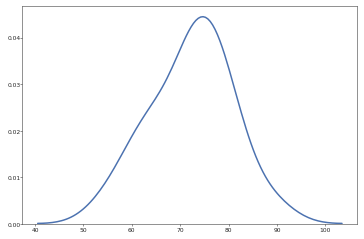

In [31]:
sns.kdeplot(pat_data.age.values)

In [39]:
print("Age is on median {0}, IQR {1} | {2}".format(np.median(pat_data.age.values.astype(float)), 
                                                   np.quantile(pat_data.age.values.astype(float), .25), 
                                                   np.quantile(pat_data.age.values.astype(float), .75)))

Age is on median 73.0, IQR 66.25 | 78.0


In [40]:
print("Age is on average {0}, SD {1}".format(np.mean(pat_data.age.values.astype(float)), 
                                                   np.std(pat_data.age.values.astype(float))))

Age is on average 72.25, SD 8.073877630977572


#### 2. Disease duration

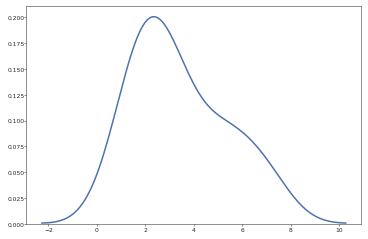

In [37]:
sns.kdeplot(pat_data.disease_duration.values)

In [38]:
print("Age is on median {0}, IQR {1} | {2}".format(np.median(pat_data.disease_duration.values.astype(float)), 
                                                   np.quantile(pat_data.disease_duration.values.astype(float), .25), 
                                                   np.quantile(pat_data.disease_duration.values.astype(float), .75)))

Age is on median 3.0, IQR 2.0 | 5.0


In [41]:
print("Age is on average {0}, SD {1}".format(np.mean(pat_data.disease_duration.values.astype(float)), 
                                                   np.std(pat_data.disease_duration.values.astype(float))))

Age is on average 3.425, SD 1.832177666057525
